# This is a Logistic Regression Model to predict if a product/food/movie review is either positive or negative.

Dataset: https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences

### Importing Libraries

In [2]:

# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pandas as pd
import random
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import os
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Importing the labelled dataset

In [5]:
from google.colab import files


uploaded = files.upload()

os.listdir()

Saving yelp_labelled.txt to yelp_labelled.txt


['.config',
 'yelp_labelled.txt',
 'imdb_labelled.txt',
 'amazon_cells_labelled.txt',
 'sample_data']

## Pre-processing the data

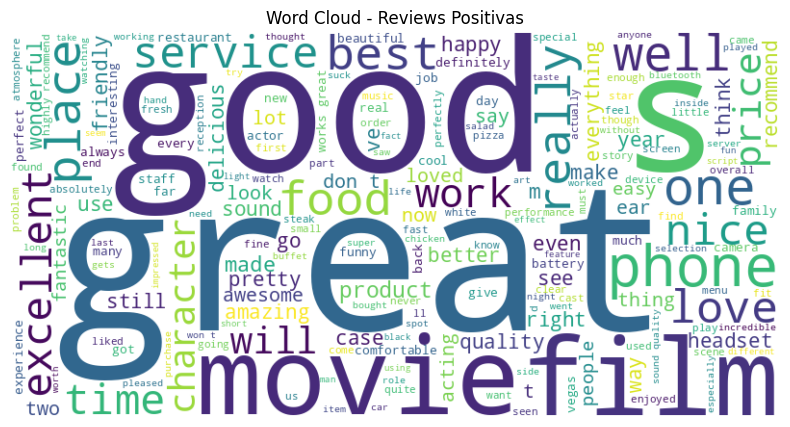

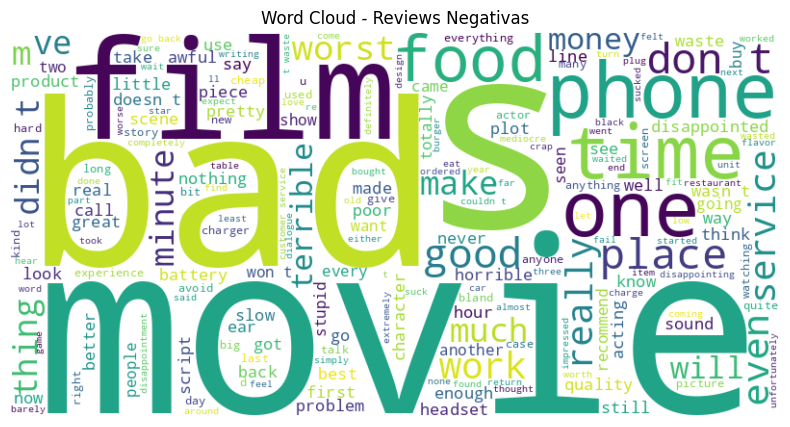

In [6]:
#data = pd.read_csv('imdb_labelled.txt', sep='\t', header=None, names=['review', 'label'])

def carregar_reviews(file_path):
    # Lê o arquivo .txt separando por tabulação (\t)
    datas = pd.read_csv(file_path, sep='\t', header=None, names=['review', 'label'])
    return datas

imdb_data = carregar_reviews("imdb_labelled.txt")
amazon_data = carregar_reviews("amazon_cells_labelled.txt")
yelp_data = carregar_reviews("yelp_labelled.txt")

# Combinando em um único DataFrame
data = pd.concat([imdb_data, amazon_data, yelp_data], ignore_index=True)

# Função de limpeza
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)    # Remove menções
    text = re.sub(r"#\w+", "", text)    # Remove hashtags
    text = re.sub(r"[^a-zA-Záéíóúçãõ ]", " ", text)  # Remove caracteres especiais
    text = text.lower()  # Converte para minúsculas
    return text

data['cleaned_review'] = data['review'].apply(clean_text) # Reviews Limpas

#Criando o WordCloud
positive_reviews = data[data['label'] == 1]['cleaned_review']
negative_reviews = data[data['label'] == 0]['cleaned_review']

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Reviews Positivas')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Reviews Negativas')
plt.axis('off')
plt.show()



In the WordCloud, it's possible to see a lot of words that don't describe any kind of feeling, like movie, film, product, thing...

### Removing words that are not important to the classifier, based on the WordCloud.

In [25]:
# Stopwords
stop_words = set(stopwords.words('english')).union({'movie', 'film', 'cinema', 'watch'})

# Remover "não" da lista de stopwords
negative_words = {
    'not', 'no', 'nor', 'neither', 'never', 'none', 'nobody', 'nothing', 'nowhere',
    'hardly', 'scarcely', 'barely', "don't", "doesn't", "didn't", "isn't", "aren't",
    "wasn't", "weren't", "won't", "wouldn't", "shan't", "shouldn't", "can't",
    "cannot", "couldn't"
}

# Remover as palavras negativas da lista de stopwords
stop_words = stop_words - negative_words

def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    return " ".join([word for word in words if word not in stop_words])

data['no_stopwords'] = data['cleaned_review'].apply(remove_stopwords)


nlp = spacy.load('en_core_web_sm') # Spacy em inglês

#Stemming
def stemming(text):
    stemmer = RSLPStemmer()
    words = nltk.word_tokenize(text, language='english')
    return " ".join([stemmer.stem(word) for word in words])

#Lemmatization
def lemmatization(text):
  doc = nlp(text)
  return " ".join([token.lemma_ for token in doc])


data['stemmed_review'] = data['no_stopwords'].apply(stemming)
data['lemmatized_review'] = data['no_stopwords'].apply(lemmatization)

data[['no_stopwords', 'stemmed_review', 'lemmatized_review', 'label']].head(10)

,no_stopwords,stemmed_review,lemmatized_review,label
0,slow moving aimless distressed drifting young man,slow moving aimles distressed drifting young man,slow move aimless distressed drift young man,0
1,not sure lost flat characters audience nearly ...,not sur lost flat charact audienc nearly half ...,not sure lose flat character audience nearly h...,0
2,attempting artiness black white clever camera ...,attempting artines black whit clev cam angl di...,attempt artiness black white clever camera ang...,0
3,little music anything speak,littl music anything speak,little music anything speak,0
4,best scene gerardo trying find song keeps runn...,best scen gerard trying find song keep running...,good scene gerardo try find song keep run head,1
5,rest lacks art charm meaning emptiness works g...,rest lack art charm meaning emptines work gues...,rest lack art charm mean emptiness work guess ...,0
6,wasted two hours,wasted two hour,waste two hour,0
7,saw today thought good effort good messages kids,saw today thought good effort good messag kid,see today think good effort good message kid,1
8,bit predictable,bit predictabl,bit predictable,0
9,loved casting jimmy buffet science teacher,loved casting jimmy buffet scienc teach,love cast jimmy buffet science teacher,1


### Generating synthetic reviews to get a bigger dataset, and a better training.

In [40]:
def generate_new_reviews(reviews, num_phrases=5):
    return " ".join(random.sample(reviews, num_phrases))

positive_reviews = data[data['label'] == 1]['lemmatized_review'].tolist()
negative_reviews = data[data['label'] == 0]['lemmatized_review'].tolist()

# Gerando reviews sintéticas
new_reviews = []
new_labels = []

for _ in range(600):
    new_reviews.append(generate_new_reviews(positive_reviews, random.randint(1, 5)))
    new_labels.append(1)

for _ in range(600):
    new_reviews.append(generate_new_reviews(negative_reviews, random.randint(1, 5)))
    new_labels.append(0)


synthetic_data = pd.DataFrame({'lemmatized_review': new_reviews, 'label': new_labels})

#shuffle the synthetic dataset
synthetic_data = synthetic_data.sample(frac=1).reset_index(drop=True)

# Combina o dataset original com as novas reviews
augmented_data = pd.concat([data, synthetic_data], ignore_index=True)

# Exibe o dataset aumentado
#print(augmented_data.head())

print(synthetic_data.head())

                                   lemmatized_review  label
0   almost song cover girl old fashioned not tuneful      0
1  seriously flavorful delight folk folk otto alw...      1
2  first charge keep go dead minute suffer need s...      0
3  excellent starter wireless headset poor talk t...      0
4  come like experience underwhelme relationship ...      0


### Testing  the SID

In [27]:

sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sid.polarity_scores(text)['compound']

data['sentiment_score'] = data['lemmatized_review'].apply(get_sentiment)

data['sentiment_score'].head(10)

,sentiment_score
0,-0.4215
1,0.0762
2,-0.6486
3,0.0000
4,0.4404
5,-0.5106
6,-0.4215
7,0.7003
8,0.0000
9,0.6369


### Organizing the training and testing data, and testing four models, to see what is the best fit for this exercise.

In [41]:
X = augmented_data['lemmatized_review']
y = augmented_data['label']

#Dividindo os dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

models = {
    'Regressão Logística': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB()
}


for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(f'{name} Acuracia: {accuracy_score(y_test, y_pred)}')

Regressão Logística Acuracia: 0.9164556962025316
SVM Acuracia: 0.9253164556962026
Random Forest Acuracia: 0.8873417721518987
Naive Bayes Acuracia: 0.9278481012658227


### Setting the hyperparameters for the two models that i intend to use

In [42]:
#GridSearch

#Usando Gridsearch
from sklearn.model_selection import GridSearchCV


#parametros
param_grid_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10, 20],
    'penalty': ['l1', 'l2']
}

#Usando Gridsearch

grid_search_LR = GridSearchCV(LogisticRegression(), param_grid_LR, cv=5, scoring='accuracy')
grid_search_LR.fit(X_train_tfidf, y_train)

# Melhores parâmetros
print(grid_search_LR.best_params_)


#Gridsearch Naive Bayes
param_grid_NB = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 20],
    'fit_prior': [True, False],
    'class_prior': [None, [0.3, 0.7], [0.5, 0.5]]
}

grid_search_NB = GridSearchCV(MultinomialNB(), param_grid_NB, cv=5, scoring='accuracy')
grid_search_NB.fit(X_train_tfidf, y_train)

print(grid_search_NB.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

{'C': 1, 'penalty': 'l2'}
{'alpha': 0.1, 'class_prior': None, 'fit_prior': False}


### Using the hyperparameters to train a Logistic Regression model

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       392
           1       0.93      0.91      0.92       398

    accuracy                           0.92       790
   macro avg       0.92      0.92      0.92       790
weighted avg       0.92      0.92      0.92       790



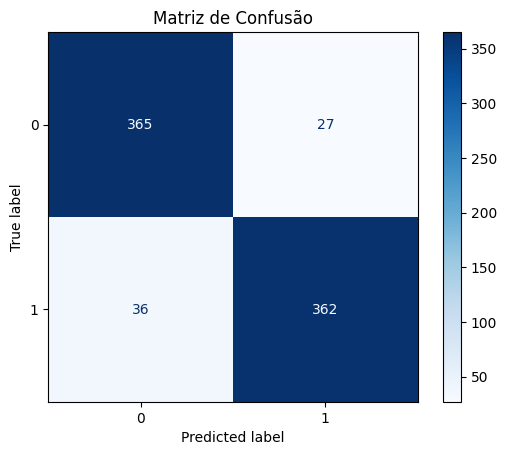

In [45]:
# Modelo de classificação
#model = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=False)
model = LogisticRegression(C=10, penalty='l2')
model.fit(X_train_tfidf, y_train)

# Previsões
y_pred = model.predict(X_test_tfidf)

# Relatório de classificação
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

Curva ROC e AUC

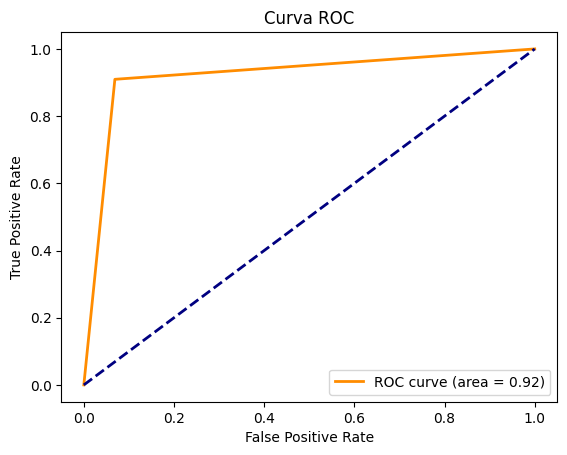

In [46]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Saving the model

In [24]:
import joblib

joblib.dump(model, 'review_classifier_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']